In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号

In [2]:
#加载数据集
def loadDataSet(path):
    dataSet = pd.read_csv(path,sep='\t',header = None)
    X = dataSet.iloc[:,:-1].values
    y = dataSet.iloc[:,-1].values.T
    return X,y

In [3]:
X,y = loadDataSet('horseColicTraining2.txt')

In [4]:
X

array([[ 2. ,  1. , 38.5, ...,  8.4,  0. ,  0. ],
       [ 1. ,  1. , 39.2, ..., 85. ,  2. ,  2. ],
       [ 2. ,  1. , 38.3, ...,  6.7,  0. ,  0. ],
       ...,
       [ 1. ,  1. , 37.5, ...,  6.8,  0. ,  0. ],
       [ 1. ,  1. , 36.5, ...,  6. ,  3. ,  3.4],
       [ 1. ,  1. , 37.2, ..., 62. ,  1. ,  1. ]])

In [5]:
y

array([-1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
       -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1

In [35]:
def noisyCount( epsilon,sensitivety=1):
    beta = sensitivety / epsilon
    n_values = []
    u1 = np.random.random()
    u2 = np.random.random()
    if u1 <= 0.5:
        n_value = -beta * np.log(1. - u2)
    else:
        n_value = beta * np.log(u2)
    return n_value

In [36]:
def laplace_mech(data, epsilon, sensitivety=1):
    for i in range(len(data)):
        data[i] += noisyCount(epsilon,sensitivety)
    return data

In [37]:
#返回分类预测结果  根据阈值所以有两种返回情况

def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    #对数据集每一列的各个特征进行阈值过滤
    retArray = np.ones((dataMatrix.shape[0], 1))
    #阈值的模式，将小于某一阈值的特征归类为-1
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    #将大于某一阈值的特征归类为-1
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [38]:
# 返回 该弱分类器单层决策树的信息  更新D向量的错误率 更新D向量的预测目标
def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)  # 将数据集和标签列表转为矩阵形式
    labelMat = np.mat(classLabels).T
    m, n = dataMatrix.shape
    numSteps = 10.0  # 步长或区间总数 最优决策树信息 最优单层决策树预测结果
    bestStump = {}      # 字典用于保存每个分类器信息
    bestClasEst = np.mat(np.zeros((m, 1)))
    minError = np.inf  # 初始化最小误差最大
    for i in range(n):  # 特征循环  （三层循环，遍历所有的可能性）
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps  #(大-小)/分割数  得到最小值到最大值需要的每一段距离
        for j in range(-1, int(numSteps) + 1):  # 遍历步长 最小值到最大值的需要次数
            for inequal in ['lt', 'gt']:  # 在大于和小于之间切换
                threshVal = (rangeMin + float(j) * stepSize)    #阈值计算公式：最小值+次数*步长  每一次从最小值走的长度
                predictedVals = stumpClassify(dataMatrix, i, threshVal,inequal)  # 最优预测目标值  用于与目标值比较得到误差
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                if weightedError < minError:    # 选出最小错误的那个特征
                    minError = weightedError    # 最小误差 后面用来更新D权值的
                    bestClasEst = predictedVals.copy()  #最优预测值
                    bestStump['dim'] = i    # 特征
                    bestStump['thresh'] = threshVal # 到最小值的距离 （得到最优预测值的那个距离）
                    bestStump['ineq'] = inequal     # 大于还是小于 最优距离为-1
    return bestStump, minError, bestClasEst

In [39]:
# 循环构建numIt个弱分类器
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []               # 保存弱分类器数组
    m = dataArr.shape[0]
    D = np.mat(np.ones((m, 1)) / m)       # D向量 每条样本所对应的一个权重
    aggClassEst = np.mat(np.zeros((m, 1)))    # 统计类别估计累积值
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)  # 加入单层决策树

        # 得到运算公式中的向量+/-α，预测正确为-α，错误则+α。每条样本一个α
        # multiply对应位置相乘  这里很聪明，用-1*真实目标值*预测值，实现了错误分类则-，正确则+
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))         # 这三步为更新概率分布D向量 拆分开来了，每一步与公式相同
        D = D / D.sum()

        #计算停止条件错误率=0 以及计算每次的aggClassEst类别估计累计值
        aggClassEst += alpha * classEst
        
        # 很聪明的计算方法 计算得到错误的个数，向量中为1则错误值
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1))) # sign返回数值的正负符号，以1、-1表示
        errorRate = aggErrors.sum() / m # 错误个数/总个数

        # print("错误率：", errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

In [40]:
# 预测 累加 多个弱分类器获得预测值*该alpha 得到 结果
def AdaClassify(datToClass, classifierArr):     #classifierArr是元组，所以在取值时需要注意
    dataMatrix = np.mat(datToClass)
    m = dataMatrix.shape[0]
    aggClassEst = np.mat(np.zeros((m, 1)))

    # 循环所有弱分类器
    for i in range(len(classifierArr[0])):
        # 获得预测结果
        classEst = stumpClassify(dataMatrix, classifierArr[0][i]['dim'],classifierArr[0][i]['thresh'],classifierArr[0][i]['ineq'])
        # 该分类器α*预测结果 用于累加得到最终的正负判断条件
        aggClassEst += classifierArr[0][i]['alpha'] * classEst  # 这里就是集合所有弱分类器的意见，得到最终的意见
        re = np.sign(aggClassEst)    # 提取数据符号
    return re,aggClassEst

In [41]:
#添加噪音
# 预测 累加 多个弱分类器获得预测值*该alpha 得到 结果
def DPsAdaClassify(datToClass, classifierArr,epsilon):     #classifierArr是元组，所以在取值时需要注意
    dataMatrix = np.mat(datToClass)
    m = dataMatrix.shape[0]
    aggClassEst = np.mat(np.zeros((m, 1)))

    # 循环所有弱分类器
    for i in range(len(classifierArr[0])):
        # 获得预测结果
        classEst = stumpClassify(dataMatrix, classifierArr[0][i]['dim'],classifierArr[0][i]['thresh'],classifierArr[0][i]['ineq'])
        #添加噪音
        classEst = laplace_mech(classEst, epsilon, sensitivety=1)
        
        # 该分类器α*预测结果 用于累加得到最终的正负判断条件
        aggClassEst += classifierArr[0][i]['alpha'] * classEst  # 这里就是集合所有弱分类器的意见，得到最终的意见
        re = np.sign(aggClassEst)    # 提取数据符号
    return re,aggClassEst

In [42]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArr = adaBoostTrainDS(datArr,labelArr,numIt=10)

In [43]:
testArr,testLabelArr = loadDataSet('horseColicTest2.txt')
pred10,agg = AdaClassify(testArr,classifierArr)
DPpred10,DPagg = DPsAdaClassify(testArr,classifierArr,epsilon=0.5)

In [44]:
acc1 = (testLabelArr == pred10.T).sum()/len(testLabelArr)
print(acc1) # 打印模型准确率

acc2 = (testLabelArr == DPpred10.T).sum()/len(testLabelArr)
print(acc2) # 打印模型准确率

0.7611940298507462
0.5970149253731343


In [45]:
epsilon = [0.05,0.1,0.25,0.5,0.75,1]
for e in epsilon:
    classifierArr = adaBoostTrainDS(datArr,labelArr,numIt=10)
    prediction10,agg= DPsAdaClassify(testArr,classifierArr,e)
    acc = (testLabelArr == prediction10.T).sum()/len(testLabelArr)
    print(acc) # 打印模型准确率

0.5671641791044776
0.47761194029850745
0.44776119402985076
0.6865671641791045
0.5970149253731343
0.5970149253731343


In [46]:
# ROC曲线：模型评估
# AUC就是曲线下面积，在比较不同的分类模型时，可以将每个模型的ROC曲线都画出来，比较曲线下面积做为模型优劣的指标。
# AUC值越大的分类器，正确率越高。
def plotROC(predStrengths, classLabels):    # 类别累计值、目标标签
    cur = (1.0, 1.0)  # 每次画线的起点游标点
    ySum = 0.0  # 用于计算AUC的值 矩形面积的高度累计值
    numPosClas = sum(np.array(classLabels) == 1.0)     # 所有真实正例    确定了在y坐标轴上的步进数目
    yStep = 1 / float(numPosClas)                           # 1/所有真实正例 y轴上的步长
    xStep = 1 / float(len(classLabels) - numPosClas)        # 1/所有真实反例 x轴上的步长
    sortedIndicies = predStrengths.argsort()  # 获得累计值向量从小到大排序的下表index [50,88,2,71...]
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # 循环所有的累计值 从小到大
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0                    #若为一个真正例，则沿y降一个步长，即不断降低真阳率；
            delY = yStep                #若为一个非真正例，则沿x退一个步长，尖笑阳率
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]      #向下移动一次，则累计一个高度。宽度不变，我们只计算高度
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b',alpha=0.8)    # 始终会有一个点是没有改变的
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0, 1], [0, 1], 'r--',alpha=0.8)
    plt.xlabel('False positive rate',fontsize=12)
    plt.ylabel('True positive rate',fontsize=12)
    plt.title('ROC curve for AdaBoost',fontsize=15)
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)  # AUC面积我们以 高*低 的矩形来计算

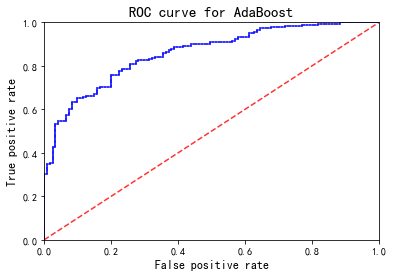

the Area Under the Curve is:  0.8582969635063604


In [47]:
#未加噪音ROC曲线
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArr = adaBoostTrainDS(datArr,labelArr,numIt=10)
pred10,agg = AdaClassify(datArr,classifierArr)
plotROC(agg.T,labelArr)

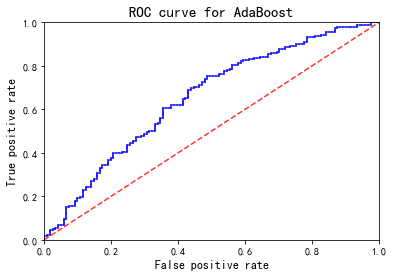

the Area Under the Curve is:  0.6521961184882524


In [48]:
#加噪音ROC曲线
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArr = adaBoostTrainDS(datArr,labelArr,numIt=10)
DPpred10,DPagg = DPsAdaClassify(datArr,classifierArr,epsilon=0.5)
plotROC(DPagg.T,labelArr)

## Adult数据集

In [50]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import OrdinalEncoder #分类特征编码包
from sklearn.model_selection import train_test_split #训练集和测试集切分包

In [51]:
df = pd.read_csv('data/adult.txt',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [52]:
df.shape #数据集的大小

(32561, 15)

In [53]:
df.isnull().sum().sum() #确认数据集没有缺失值

0

In [54]:
#确认是否有样本不均衡问题
df.iloc[:,-1].value_counts()

 <=50K    24720
 >50K      7841
Name: 14, dtype: int64

In [55]:
#解决样本不均衡问题：这里采用下采样(将多数类的数量减少)
df0 = df[df.iloc[:,-1]==' <=50K'].sample(8000) 
df1 = df[df.iloc[:,-1]!=' <=50K']

df_adult = pd.concat([df0,df1])
df_adult.index = range(df_adult.shape[0])
df_adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,21,Private,34506,HS-grad,9,Separated,Other-service,Own-child,White,Female,0,0,35,United-States,<=50K
1,26,Private,183965,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,29,Private,253003,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,16,United-States,<=50K
3,60,Private,227332,Assoc-voc,11,Widowed,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,28,Private,90915,Bachelors,13,Married-spouse-absent,Tech-support,Unmarried,Black,Female,0,0,40,United-States,<=50K


In [56]:
#对文本型特征进行编码
for i in range(df_adult.shape[1]-1):  #对每一列特征进行循环
    if df_adult.iloc[:,i].dtype=='O': #判断特征中的对象是否是文本型
        #对分类型特征进行编码
        df_adult.iloc[:,i] = OrdinalEncoder().fit_transform(df_adult.iloc[:,i].values.reshape(-1, 1))
    else:
        #把整数型特征变为float,加快后面的计算
        df_adult.iloc[:,i] = df_adult.iloc[:,i].astype('float64')

In [57]:
#对标签进行编码，正样本('<=50K')为1，负样本('>50K')为-1
df_adult.iloc[:,-1]=[1.0 if label.strip() == '<=50K' else -1.0 for label in df_adult.iloc[:,-1]]

In [58]:
df_adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,21.0,4.0,34506.0,11.0,9.0,5.0,8.0,3.0,4.0,0.0,0.0,0.0,35.0,38.0,1.0
1,26.0,4.0,183965.0,11.0,9.0,4.0,3.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0,1.0
2,29.0,4.0,253003.0,11.0,9.0,4.0,6.0,1.0,4.0,1.0,0.0,0.0,16.0,38.0,1.0
3,60.0,4.0,227332.0,8.0,11.0,6.0,1.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0,1.0
4,28.0,4.0,90915.0,9.0,13.0,3.0,13.0,4.0,2.0,0.0,0.0,0.0,40.0,38.0,1.0


In [59]:
#提取特征矩阵和标签
X = df_adult.iloc[:,:-1]
y = df_adult.iloc[:,-1]

In [60]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,21.0,4.0,34506.0,11.0,9.0,5.0,8.0,3.0,4.0,0.0,0.0,0.0,35.0,38.0
1,26.0,4.0,183965.0,11.0,9.0,4.0,3.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0
2,29.0,4.0,253003.0,11.0,9.0,4.0,6.0,1.0,4.0,1.0,0.0,0.0,16.0,38.0
3,60.0,4.0,227332.0,8.0,11.0,6.0,1.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0
4,28.0,4.0,90915.0,9.0,13.0,3.0,13.0,4.0,2.0,0.0,0.0,0.0,40.0,38.0
5,51.0,6.0,291755.0,5.0,4.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,42.0,38.0
6,20.0,4.0,247794.0,11.0,9.0,4.0,12.0,1.0,4.0,0.0,0.0,0.0,84.0,38.0
7,34.0,4.0,182401.0,7.0,12.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,40.0,38.0
8,42.0,4.0,103932.0,8.0,11.0,0.0,10.0,4.0,4.0,0.0,0.0,0.0,40.0,38.0
9,18.0,4.0,130849.0,1.0,7.0,4.0,8.0,3.0,4.0,0.0,0.0,0.0,8.0,38.0


In [61]:
#切分训练集和测试集
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3) #70%的数据作为训练集，30%的数据作为测试集

In [62]:
Xtrain.shape #训练集的数量

(11088, 14)

In [63]:
Ytrain.value_counts() #查看样本标签

 1.0    5601
-1.0    5487
Name: 14, dtype: int64

In [64]:
#将训练集带入模型
datArr,labelArr = Xtrain.values, Ytrain.values
classifierArr = adaBoostTrainDS(datArr,labelArr,10)

In [65]:
#查看模型在测试集上的表现
testArr,testlabel = Xtest.values,Ytest.values #测试集的特征矩阵和标签
predict10,agg = DPsAdaClassify(testArr,classifierArr,epsilon=0.01)   #模型对测试集的预测结果
acc = (predict10.T==testlabel).sum()/len(testlabel) #计算模型的分类准确率
print(f'加噪音模型在测试集上的准确率为：{acc}') #打印模型准确率

加噪音模型在测试集上的准确率为：0.4963181148748159


In [57]:
# 绘制基分类器个数学习曲线
datArr,labelArr = Xtrain.values, Ytrain.values #训练集的特征和标签
testArr,testlabel = Xtest.values,Ytest.values  #测试集的特征和标签

score0 = [] #测试集上的准确率
for i in range(10,1010,100):
    classifierArr0 = adaBoostTrainDS(datArr,labelArr,i)
    pred0,agg0 = AdaClassify(testArr,classifierArr0)   #模型对测试集的预测结果
    acc0 = (pred0.T==testlabel).sum()/len(testlabel) #计算模型在测试集上的准确率
    score0.append(acc0)
    
print(f'最优基分类器个数：{score0.index(max(score0))*100+10}')
print(f'模型最高准确率：{max(score0)}')

最优基分类器个数：910
模型最高准确率：0.8266358089627603


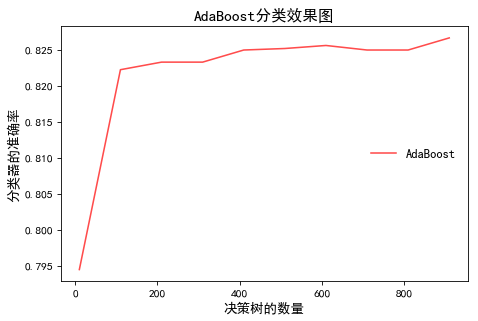

In [58]:
#绘制曲线图
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(10,1010,100),score0,c='r',alpha=.7,label='AdaBoost')
plt.legend(loc=7,frameon=False,fontsize=12)
plt.title('AdaBoost分类效果图',fontsize=15)
plt.xlabel('决策树的数量',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

In [60]:
# 细化基分类器个数学习曲线
score1 = []
for i in range(10,210,10):
    classifierArr1 = adaBoostTrainDS(datArr,labelArr,i)
    predict1,agg1 = AdaClassify(testArr,classifierArr1)   #模型对测试集的预测结果
    acc1 = (predict1.T==testlabel).sum()/len(testlabel) #计算模型的准确率
    score1.append(acc1)

print(f'最优基分类器个数：{score1.index(max(score1))*10+10}')
print(f'模型最高准确率：{max(score1)}')

最优基分类器个数：90
模型最高准确率：0.8245318746055124


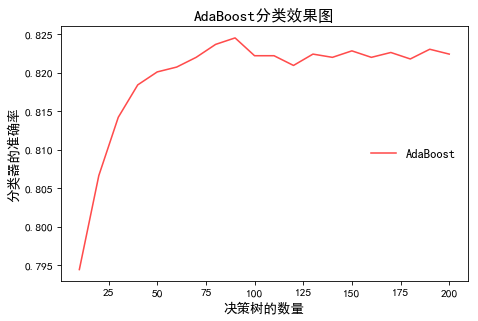

In [61]:
#绘制曲线图
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(10,210,10),score1,c='r',alpha=.7,label='AdaBoost')
plt.legend(loc=7,frameon=False,fontsize=12)
plt.title('AdaBoost分类效果图',fontsize=15)
plt.xlabel('决策树的数量',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

In [69]:
# 再次细化基分类器个数学习曲线
score2 = []
dp005 = []
dp01 = []
dp025 = []
dp05 = []
dp075 = []
dp1 =[]
for i in range(1,102,10):
    classifierArr2 = adaBoostTrainDS(datArr,labelArr,i)
    predict2,agg2 = AdaClassify(testArr,classifierArr2)   #模型对测试集的预测结果
    acc2 = (predict2.T==testlabel).sum()/len(testlabel) #计算模型的准确率
    score2.append(acc2)
    
    pre005,agg005 = DPsAdaClassify(testArr,classifierArr2,0.05)
    dpacc005 = (pre005.T==testlabel).sum()/len(testlabel)
    dp005.append(dpacc005)
    
    pre01,agg01 = DPsAdaClassify(testArr,classifierArr2,0.1)
    dpacc01 = (pre01.T==testlabel).sum()/len(testlabel)
    dp01.append(dpacc01)
    
    pre025,agg025 = DPsAdaClassify(testArr,classifierArr2,0.25)
    dpacc025 = (pre025.T==testlabel).sum()/len(testlabel)
    dp025.append(dpacc025)
    
    pre05,agg05 = DPsAdaClassify(testArr,classifierArr2,0.5)
    dpacc05 = (pre05.T==testlabel).sum()/len(testlabel)
    dp05.append(dpacc05)
    
    pre075,agg075 = DPsAdaClassify(testArr,classifierArr2,0.75)
    dpacc075 = (pre075.T==testlabel).sum()/len(testlabel)
    dp075.append(dpacc075)
    
    pre1,agg1 = DPsAdaClassify(testArr,classifierArr2,1)
    dpacc1 = (pre1.T==testlabel).sum()/len(testlabel)
    dp1.append(dpacc1)
    

print(f'最优基分类器个数：{score2.index(max(score2))*10+1}')
print(f'模型最高准确率：{max(score2)}')

最优基分类器个数：71
模型最高准确率：0.8163265306122449


In [71]:
#用单层决策树对数据集进行预测
from sklearn.tree import DecisionTreeClassifier as DTC
clf = DTC(max_depth=1) #实例化单层决策树
clf = clf.fit(Xtrain,Ytrain)
score_c = clf.score(Xtest,Ytest)
score_c

0.7338523038081212

In [72]:
DTC_score = []
for i in range(10):
    clf = DTC(max_depth=i+1)
    clf = clf.fit(Xtrain,Ytrain)
    DTC_score.append(clf.score(Xtest,Ytest))

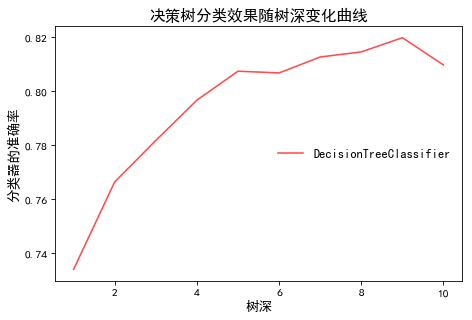

In [73]:
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(1,11),DTC_score,c='r',alpha=.7,label='DecisionTreeClassifier')
plt.legend(loc=7,frameon=False,fontsize=12)
plt.title('决策树分类效果随树深变化曲线',fontsize=15)
plt.xlabel('树深',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

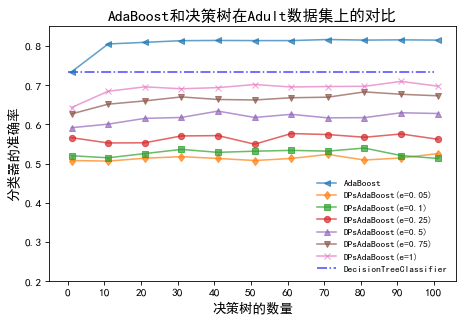

In [76]:
#绘制决策树和adaboost的对比效果图
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(1,102,10),score2,alpha=.7,marker='<',label='AdaBoost')
plt.plot(range(1,102,10),dp005,alpha=.7,marker='d',label='DPsAdaBoost(e=0.05)')
plt.plot(range(1,102,10),dp01,alpha=.7,marker='s',label='DPsAdaBoost(e=0.1)')
plt.plot(range(1,102,10),dp025,alpha=.7,marker='o',label='DPsAdaBoost(e=0.25)')
plt.plot(range(1,102,10),dp05,alpha=.7,marker='^',label='DPsAdaBoost(e=0.5)')
plt.plot(range(1,102,10),dp075,alpha=.7,marker='v',label='DPsAdaBoost(e=0.75)')
plt.plot(range(1,102,10),dp1,alpha=.7,marker='x',label='DPsAdaBoost(e=1)')

plt.hlines(score_c,0,100,colors='b',alpha=.7,linestyles='dashdot',label='DecisionTreeClassifier')
plt.legend(loc=4,frameon=False,fontsize=9)
plt.title('AdaBoost和决策树在Adult数据集上的对比',fontsize=15)
plt.xlabel('决策树的数量',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(range(0,102,10),fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.2,0.85)
plt.savefig('AdaBoost和决策树在Adult数据集上的对比.png');

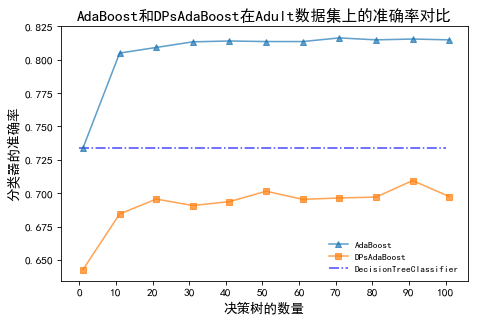

In [77]:
#绘制决策树和adaboost的对比效果图
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(1,102,10),score2,alpha=.7,marker='^',label='AdaBoost')
plt.plot(range(1,102,10),dp1,alpha=.7,marker='s',label='DPsAdaBoost')

plt.hlines(score_c,0,100,colors='b',alpha=.7,linestyles='dashdot',label='DecisionTreeClassifier')
plt.legend(loc=4,frameon=False,fontsize=9)
plt.title('AdaBoost和DPsAdaBoost在Adult数据集上的准确率对比',fontsize=15)
plt.xlabel('决策树的数量',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(range(0,102,10),fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('AdaBoost和DPsAdaBoost在Adult数据集上的准确率对比.png');

In [78]:
# 从曲线中可以看出，30个左右的基分类器基本上已达到模型上限
classifierArr3 = adaBoostTrainDS(datArr,labelArr,30) #训练30个基分类器的模型
predict3,agg3 = AdaClassify(testArr,classifierArr3)   #模型对测试集的预测结果
acc3 = (predict3.T==testlabel).sum()/len(testlabel) #计算模型的准确率
print(f'模型在测试集上的准确率为：{acc3}') #打印模型准确率

模型在测试集上的准确率为：0.812960235640648


In [79]:
#epsilon曲线
epsilon = [0.05,0.1,0.25,0.5,0.75,1.0]

DPscor4 = []
for e in epsilon:
    classifierArr4 = adaBoostTrainDS(datArr,labelArr,30) #训练30个基分类器的模型
    DPpred4,agg4 = DPsAdaClassify(testArr,classifierArr4,e)   #模型对测试集的预测结果
    DPacc4 = (DPpred4.T==testlabel).sum()/len(testlabel) #计算模型的准确率
    DPscor4.append(DPacc4)

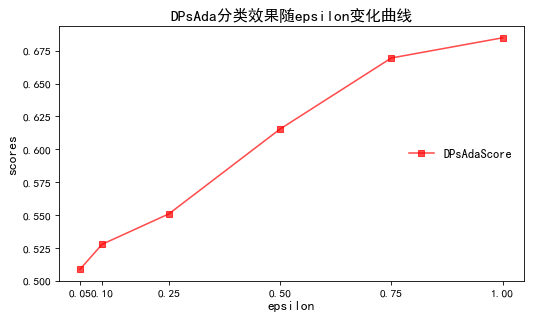

In [80]:
plt.figure(figsize=(8,4.5),dpi=75)
plt.plot(epsilon,DPscor4,c='r',alpha=.7,marker='s',label='DPsAdaScore')
plt.legend(loc=7,frameon=False,fontsize=12)
plt.title('DPsAda分类效果随epsilon变化曲线',fontsize=15)
plt.xlabel('epsilon',fontsize=13)
plt.ylabel('scores',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(epsilon)
plt.savefig('DPsAda分类效果随epsilon变化曲线.png');

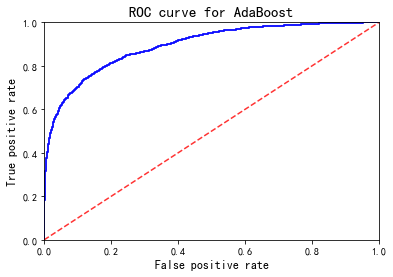

the Area Under the Curve is:  0.894245921288928


In [81]:
# 绘制ROC曲线(未添加噪音的30个弱分类器)
classifierArr3 = adaBoostTrainDS(datArr,labelArr,30) #训练30个基分类器的模型
predict3,agg3 = AdaClassify(datArr,classifierArr3)   
plotROC(agg3.T,labelArr)

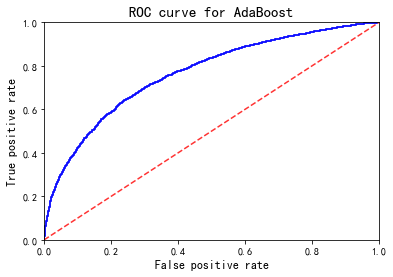

the Area Under the Curve is:  0.7652264183733305


In [82]:
# 绘制ROC曲线(添加噪音的30个弱分类器)
classifierArr4 = adaBoostTrainDS(datArr,labelArr,30) #训练30个基分类器的模型
predict4,agg4 = DPsAdaClassify(datArr,classifierArr4,1)   
plotROC(agg4.T,labelArr)

In [41]:
# 样本数量与模型准确率之间的关系
acc_train = []
acc_test = []
for i in range(1000):
    xtrain = datArr[:i+1]
    ytrain = labelArr[:i+1]
    classifierArr4 = adaBoostTrainDS(xtrain,ytrain,30)    #训练30个基分类器的模型
    pre1 = adaClassify(xtrain,classifierArr4)             #模型对训练集的预测结果
    pre2 = adaClassify(testArr,classifierArr4)            #模型对测试集的预测结果
    acc1 = (pre1.T==ytrain).sum()/len(ytrain)             #计算模型对训练集的准确率
    acc2 = (pre2.T==testlabel).sum()/len(testlabel)       #计算模型对测试集的准确率
    acc_train.append(acc1)
    acc_test.append(acc2)

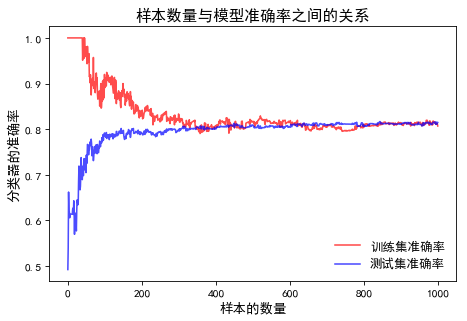

In [42]:
# 绘制样本数量与模型准确率之间的关系图
plt.figure(figsize=(7,4.5),dpi=75)
plt.plot(range(1000),acc_train,c='r',alpha=.7,label='训练集准确率')
plt.plot(range(1000),acc_test,c='b',alpha=.7,label='测试集准确率')
plt.legend(loc=4,frameon=False,fontsize=12)
plt.title('样本数量与模型准确率之间的关系',fontsize=15)
plt.xlabel('样本的数量',fontsize=13)
plt.ylabel('分类器的准确率',fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);